# Chuẩn bị dữ liệu

Phần này được thực hiện bởi 2 teammate Lực, Kiệt. Có 1 gap giữa phần này và phần chạy model của Trí, Quý.

Import Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import os
import shutil

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from imageio import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

## Khởi tạo, tải dữ liệu gốc
Các hằng số (paths) được khai báo

In [ ]:
# !gdown --folder https://drive.google.com/drive/u/0/folders/1DOHxFGrMVLA199TlO5A2TJ5Yh4IsuXCY --remaining-ok
!gdown --id 19Rr-b09YUjcmgc6_mJyTZHSOsr-ZPNNP
!unzip -qq /content/animals.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19Rr-b09YUjcmgc6_mJyTZHSOsr-ZPNNP
From (redirected): https://drive.google.com/uc?id=19Rr-b09YUjcmgc6_mJyTZHSOsr-ZPNNP&confirm=t&uuid=7662d450-b872-4f3e-abb7-8a12383ccddb
To: /content/animals.zip
100% 193M/193M [00:04<00:00, 42.6MB/s]


In [ ]:
DATA_PATH = r'/content/animals'
FILTERED_PATH = '/content/filtered-image'

CONFIDENCE_SCORE = 0.50
BLOCK_LABEL = 3
try: shutil.rmtree(FILTERED_PATH) # xóa folder trước
except: pass

label_list = os.listdir(DATA_PATH)
print(label_list)

!mkdir {FILTERED_PATH}
for label in label_list:
    os.makedirs(os.path.join(FILTERED_PATH, label))

['vicuna', 'water_buffalo', 'tapir', 'anteater', 'camel', 'snow_leopard', 'african_elephant', 'warthog', 'wildebeest', 'porcupine', 'squirrel', 'jackal', 'kangaroo', 'red_panda', 'mongoose', 'dolphin', 'wombat', 'polar_bear', 'sugar_glider', 'mountain_goat', 'vampire_bat', 'blue_whale', 'walrus', 'armadillo', 'opossum', 'highland_cattle', 'brown_bear', 'orangutan', 'horse', 'badger', 'groundhog', 'rhinoceros', 'baboon', 'seal', 'yak', 'alpaca', 'giraffe', 'manatee', 'weasel', 'sea_lion', 'zebra', 'arctic_fox', 'koala', 'otter', 'american_bison']


## Hàm Train SVM Model
A simple model to detect hard images and remove them automatically

In [ ]:
def train_svm_model (train_images, train_labels, image_names):
    X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, shuffle=True)

    scaler = StandardScaler()

    scaler.fit(X_train)
    # Transform training and test data
    scaled_train_features = scaler.transform(X_train)
    scaled_test_features = scaler.transform(X_test)
    svm_model = SVC(kernel='linear', probability=True)

    print("Training SVM Model............")
    svm_model.fit(scaled_train_features, y_train)
    predictions = svm_model.predict(scaled_test_features)

    accuracy = accuracy_score(y_test, predictions)
    print(f'Accuracy: {accuracy:.2f}')
    print(classification_report(y_test, predictions))

    train_images_scaler = scaler.transform(train_images)
    print(f'Predicions\' probabilities on all images passed....')
    probs = svm_model.predict_proba(train_images_scaler)

    return probs

## Hàm lọc data

In [ ]:
def copy_image(src_path, dst_path, label, img_name):
    src = os.path.join(src_path, label, img_name)
    dst = os.path.join(dst_path, label, img_name)
    shutil.copyfile(src, dst)

def filter_data(train_images, train_labels, image_names, times):
    probs = train_svm_model(np.array(train_images), np.array(train_labels), np.array(image_names))
    print("--- PERFORMING FILTER PROCESS ---")
    cnt_filtered = 0
    for index, y_pred in enumerate(probs):
        pred = np.argmax(y_pred)
        if train_labels[index] != pred + times * BLOCK_LABEL or y_pred[pred] < CONFIDENCE_SCORE: # đoán sai hoặc đoán đúng nhưng confidence thấp
            cnt_filtered = cnt_filtered + 1
            copy_image(DATA_PATH, FILTERED_PATH, label_list[train_labels[index]], image_names[index])

    print(f'Filtered {cnt_filtered}/{len(train_images)}')

## Tiến hành lọc

In [ ]:
train_images = []
train_labels = []
image_names  = []

times = 0
for index_label, label in enumerate(label_list):
    images_path = os.path.join(DATA_PATH, label)

    print(f'Start Loading label: {label}')
    for image_name in os.listdir(images_path):
        path = os.path.join(images_path, image_name)
        image = imread(path)
        # image = resize(image, (image.shape[0] // 2, image.shape[1] // 2, image.shape[2]), anti_aliasing=True) #(256, 256, 3) -> (128, 128, 3)

        image = image.flatten()
        train_images.append(image)
        train_labels.append(index_label)
        image_names.append(image_name)

    if index_label % BLOCK_LABEL == BLOCK_LABEL - 1: # tiến hành lọc, phân biệt trên (BLOCK_LABEL = 3) labels mỗi lần (15 lần chạy)
        print(f'Start Filtering from label[{index_label - 2}] to label[{index_label}]')
        filter_data(train_images, train_labels, image_names, times)
        # print(len(train_images), len(train_labels), image_names[0])
        train_images = []
        train_labels = []
        image_names  = []
        times = times + 1


Ở đây, có thể các bạn đã có một logic gì đó để tạo file filtered-name.txt cho mỗi class (label) rồi upload vào thư mục chung filtered-name. Không cần phải upload toàn bộ tập các ảnh đã lọc

# Tải dữ liệu

## Xóa ảnh (trên Drive chung)
Bước này dựa vào danh sách .txt đã tạo ở bước trước để lọc ra và lưu trên drive chung.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In order for this line of code to work, add shortcut to your Drive first

In [ ]:
# prompt: download this file https://drive.google.com/file/d/1cqdg5uQz2PyeX04MJ3W48NpBm26aMuPh/view?usp=drive_link

!gdown --id 1cqdg5uQz2PyeX04MJ3W48NpBm26aMuPh


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cqdg5uQz2PyeX04MJ3W48NpBm26aMuPh
To: /content/filtered-name.zip
100% 21.0k/21.0k [00:00<00:00, 73.4MB/s]


In [ ]:
import os
project_dir = '/content/drive/MyDrive/CV 1: Animal Image Classification/'
filter_path = project_dir + 'filtered-name/'
%cd {filter_path}

folders = [f for f in os.listdir(filter_path) if os.path.isdir(os.path.join(filter_path, f))]

for folder in folders:
    print(folder)

[Errno 2] No such file or directory: '/content/drive/MyDrive/CV 1: Animal Image Classification/filtered-name/'
/content


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/CV 1: Animal Image Classification/filtered-name/'

In [ ]:
!unzip {project_dir}/animals.zip -d {project_dir}

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/drive/MyDrive/bé tập Ây Ai/animals/red_panda/red_panda-0250.jpg  
  inflating: /content/drive/MyDrive/bé tập Ây Ai/animals/red_panda/red_panda-0251.jpg  
  inflating: /content/drive/MyDrive/bé tập Ây Ai/animals/red_panda/red_panda-0252.jpg  
  inflating: /content/drive/MyDrive/bé tập Ây Ai/animals/red_panda/red_panda-0253.jpg  
  inflating: /content/drive/MyDrive/bé tập Ây Ai/animals/red_panda/red_panda-0254.jpg  
  inflating: /content/drive/MyDrive/bé tập Ây Ai/animals/red_panda/red_panda-0255.jpg  
  inflating: /content/drive/MyDrive/bé tập Ây Ai/animals/red_panda/red_panda-0256.jpg  
  inflating: /content/drive/MyDrive/bé tập Ây Ai/animals/red_panda/red_panda-0257.jpg  
  inflating: /content/drive/MyDrive/bé tập Ây Ai/animals/red_panda/red_panda-0258.jpg  
  inflating: /content/drive/MyDrive/bé tập Ây Ai/animals/red_panda/red_panda-0259.jpg  
  inflating: /content/d

In [ ]:
import os

image_path = project_dir + 'animals'
folders = [f for f in os.listdir(image_path) if os.path.isdir(os.path.join(image_path, f))]

print(len(folders))

In [ ]:
for folder in folders:
  file_path = f'{folder}/filtered-name.txt'

  with open(file_path, 'r') as file:
    for line in file:
      img = line.strip()
      path_img = f'{image_path}/{folder}/{img}'
      if os.path.exists(path_img):
        os.remove(path_img)
      else:
        print(f"The file {path_img} does not exist.")

## Load data

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import numpy as np
import os

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import numpy as np
import os

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    image_path,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    image_path,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='validation'
)

## Check SVM's performance
Kiểm thử hiệu suất của SVM trên tập dữ liệu rút gọn

In [ ]:
train_images = []
train_labels = []
image_names  = []

times = 0
for index_label, label in enumerate(label_list):
    images_path = os.path.join(DATA_PATH, label)

    print(f'Start Loading label: {label}')
    for image_name in os.listdir(images_path):
        path = os.path.join(images_path, image_name)
        image = imread(path)

        image = image.flatten()
        train_images.append(image)
        train_labels.append(index_label)
        image_names.append(image_name)

    predictions_proba = train_svm_model(np.array(train_images), np.array(train_labels), np.array(image_names))
    train_images = []
    train_labels = []
    image_names  = []
    times = times + 1


# Khởi tạo mô hình + TN1
Thí nghiệm 1: Chạy các mô hình trên bộ ảnh chưa augment

## Helpers

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW

from matplotlib import pyplot as plt
import json


import datetime

from matplotlib import pyplot as plt
import json

def plot_learning_curve(history_dict, name=''):
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(history_dict['loss'], label='Train Loss')
  plt.plot(history_dict['val_loss'], label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history_dict['accuracy'], label='Train Accuracy')
  plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  if name == '': name = datetime.datetime.now().strftime('%b-%d %H_%M_%S')
  plt.savefig(f'{name}')
  plt.show()

model_path = f'{project_dir}/model and history'
def save_model(model, name=''):
  if name == '': name = datetime.datetime.now().strftime('%b-%d %H_%M_%S')
  #plot_learning_curve(history_dict, name)
  model.save(f'{model_path}/{name}.h5')
  #with open(f'{model_path}/history_{name}.json', 'w') as f:
  #  json.dump(history_dict, f)

## CNN

 CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW

def create_cnn_model():
    cnn_model = models.Sequential()
    cnn_model.add(layers.Conv2D(16, (7, 7), padding='same', activation='relu', input_shape=(224, 224, 3)))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Conv2D(32, (5, 5), padding='same', activation='relu'))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Flatten())

    cnn_model.add(layers.Dense(1352, activation='relu'))
    cnn_model.add(layers.Dropout(0.2))
    cnn_model.add(layers.Dense(45, activation='softmax'))

    cnn_model.compile(optimizer=AdamW(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return cnn_model

cnn_model = create_cnn_model()
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 16)        │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 32)        │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1352)                │      67,839,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1352)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 45)                  │          60,885 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,933,949 (259.15 MB)

 Trainable params: 67,933,917 (259.15 MB)

 Non-trainable params: 32 (128.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
CNN_History = cnn_model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.1161 - loss: 3.6011 

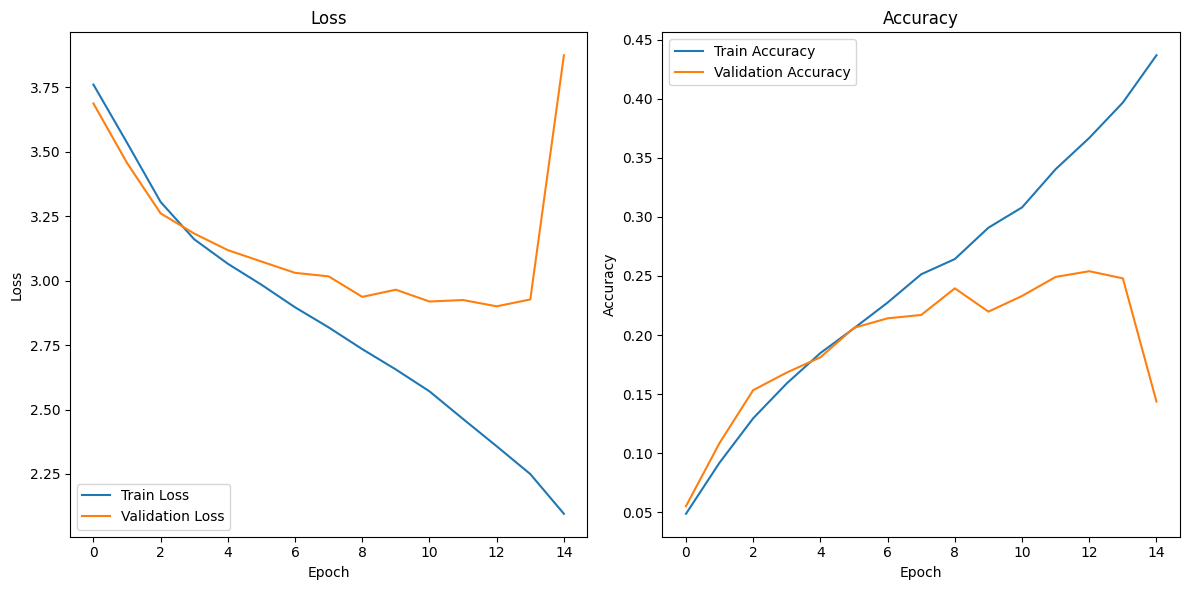

In [ ]:
plot_learning_curve(CNN_History.history)
save_model(cnn_model, 'CNN_aug=0')

## VGG16

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD

def create_vgg16_model():
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in vgg16_base.layers: layer.trainable = False

    vgg_model = models.Sequential([
        vgg16_base,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(45, activation='softmax')
    ])

    vgg_model.compile(optimizer=AdamW(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return vgg_model

vgg_model = create_vgg16_model()
vgg_model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
VGG16_hist = vgg_model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


314/314 ━━━━━━━━━━━━━━━━━━━━ 72s 179ms/step - accuracy: 0.0807 - loss: 3.6823 - val_accuracy: 0.2564 - val_loss: 3.0968
Epoch 2/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - accuracy: 0.3128 - loss: 2.8522 - val_accuracy: 0.3937 - val_loss: 2.5289
Epoch 3/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 131ms/step - accuracy: 0.4557 - loss: 2.3072 - val_accuracy: 0.4670 - val_loss: 2.1953
Epoch 4/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - accuracy: 0.5338 - loss: 1.9538 - val_accuracy: 0.4988 - val_loss: 1.9763
Epoch 5/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - accuracy: 0.5965 - loss: 1.7080 - val_accuracy: 0.5596 - val_loss: 1.7999
Epoch 6/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - accuracy: 0.6420 - loss: 1.5402 - val_accuracy: 0.5733 - val_loss: 1.6817
Epoch 7/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 44s 136ms/step - accuracy: 0.6797 - loss: 1.3758 - val_accuracy: 0.5866 - val_loss: 1.6024
Epoch 8/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 131ms/step - accuracy: 0.6967 - loss: 1.2820 - val

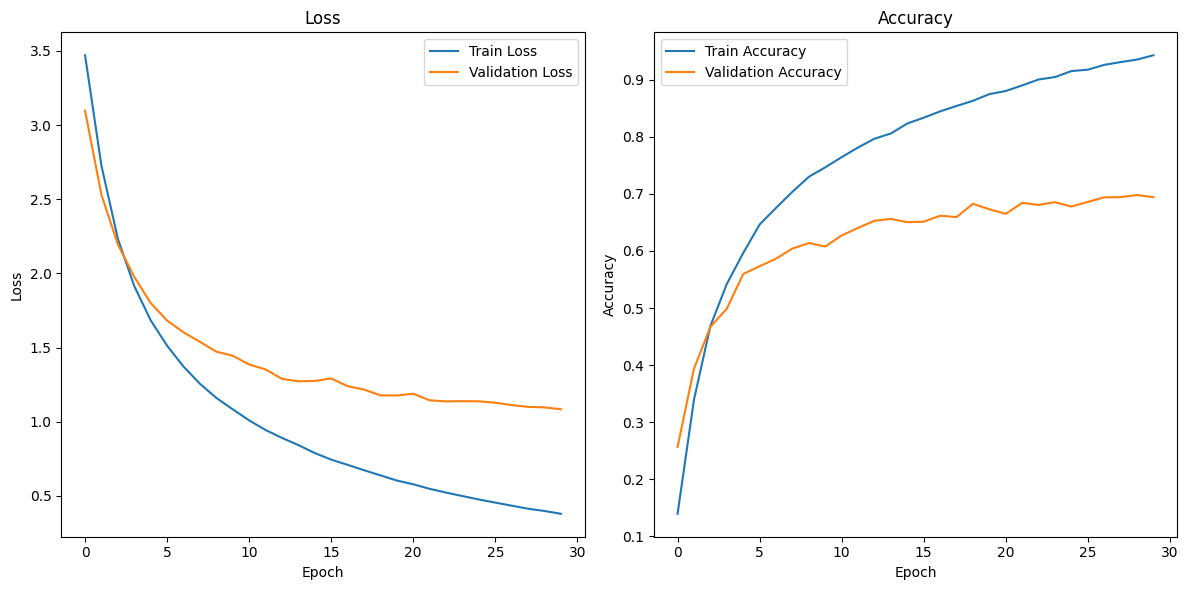

In [ ]:
plot_learning_curve(VGG16_hist.history)
save_model(vgg_model, 'VGG16_frozen_aug=0')

In [ ]:
# Mở khóa các lớp mô hình để fine-tuning
for layer in vgg_model.layers[0].layers: layer.trainable = True
vgg_model.compile(optimizer=AdamW(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
VGG16_hist_fine_tuning = vgg_model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 123s 298ms/step - accuracy: 0.9525 - loss: 0.3172 - val_accuracy: 0.7198 - val_loss: 0.9885
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 88s 278ms/step - accuracy: 0.9550 - loss: 0.2615 - val_accuracy: 0.7230 - val_loss: 0.9719
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 88s 277ms/step - accuracy: 0.9574 - loss: 0.2398 - val_accuracy: 0.7246 - val_loss: 0.9664
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 88s 279ms/step - accuracy: 0.9582 - loss: 0.2224 - val_accuracy: 0.7267 - val_loss: 0.9653
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 88s 278ms/step - accuracy: 0.9573 - loss: 0.2139 - val_accuracy: 0.7250 - val_loss: 0.9656
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 88s 276ms/step - accuracy: 0.9575 - loss: 0.2104 - val_accuracy: 0.7238 - val_loss: 0.9683
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 88s 279ms/step - accuracy: 0.9573 - loss: 0.1997 - val_accuracy: 0.7234 - val_loss: 0.9703
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 87s 275ms/step - accuracy: 0.9632 - loss: 

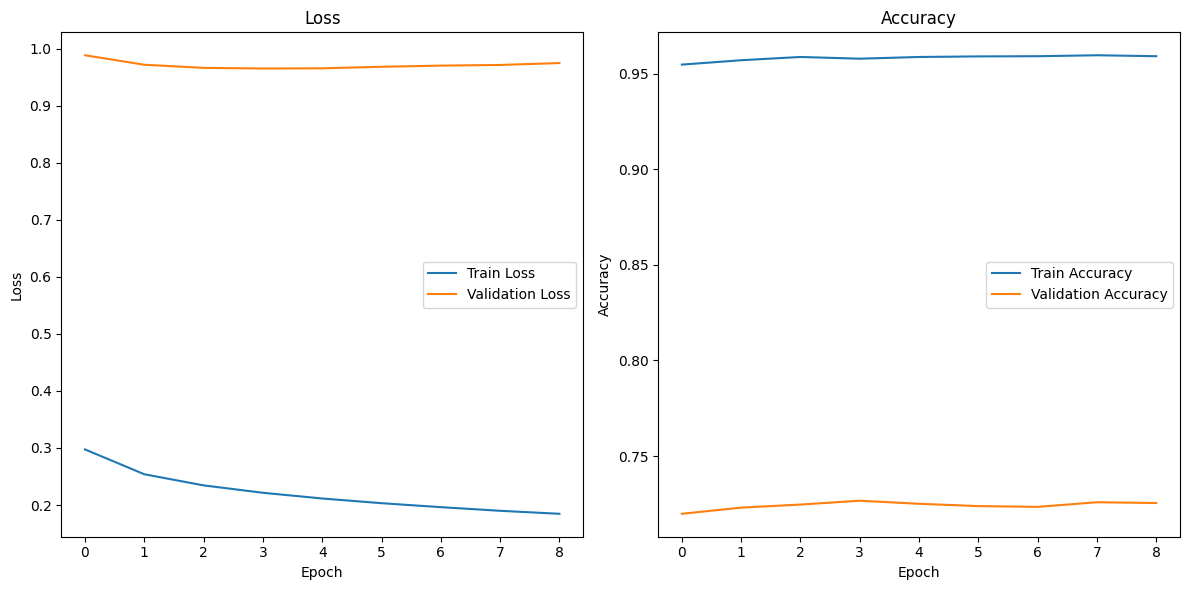

In [ ]:
plot_learning_curve(VGG16_hist_fine_tuning.history)
save_model(vgg_model, 'VGG16_aug=0')

# Thí nghiệm 1: Xét độ hiệu quả của phép augment data

## Load data with augmentation

In [ ]:
image_path = '/content/drive/MyDrive/bé tập Ây Ai/Project 1 - CV - Animal Image Classification/animals'

In [ ]:
datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0/255.0,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'
)

train_generator = datagen.flow_from_directory(
    image_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    image_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 10018 images belonging to 45 classes.
Found 2484 images belonging to 45 classes.


## Run CNN and VGG on augmented data

In [ ]:
cnn_model = create_cnn_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
CNN_History = cnn_model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


314/314 ━━━━━━━━━━━━━━━━━━━━ 7084s 22s/step - accuracy: 0.0944 - loss: 3.6887 - val_accuracy: 0.1622 - val_loss: 3.4001
Epoch 2/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 173s 543ms/step - accuracy: 0.1918 - loss: 3.0972 - val_accuracy: 0.2190 - val_loss: 3.0113
Epoch 3/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 183s 572ms/step - accuracy: 0.2092 - loss: 2.9387 - val_accuracy: 0.2436 - val_loss: 2.8830
Epoch 4/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 179s 561ms/step - accuracy: 0.2435 - loss: 2.8281 - val_accuracy: 0.2512 - val_loss: 2.8476
Epoch 5/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 161s 502ms/step - accuracy: 0.2755 - loss: 2.6924 - val_accuracy: 0.2637 - val_loss: 2.8161
Epoch 6/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 161s 503ms/step - accuracy: 0.2909 - loss: 2.6320 - val_accuracy: 0.3100 - val_loss: 2.6258
Epoch 7/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 163s 508ms/step - accuracy: 0.3121 - loss: 2.5348 - val_accuracy: 0.2842 - val_loss: 2.6500
Epoch 8/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 159s 496ms/step - accuracy: 0.3218 - loss: 2.483

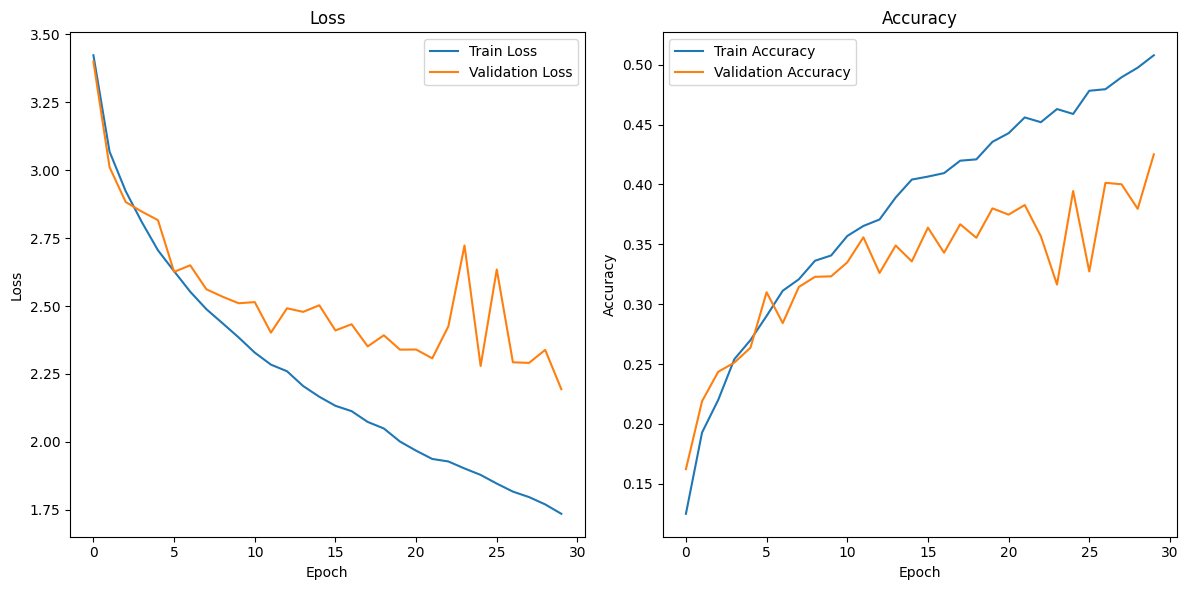

In [20]:
plot_learning_curve(CNN_History.history)
save_model(cnn_model, 'CNN_aug=1')

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD

def create_vgg16_model():
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in vgg16_base.layers: layer.trainable = False

    vgg_model = models.Sequential([
        vgg16_base,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(45, activation='softmax')
    ])

    vgg_model.compile(optimizer=AdamW(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return vgg_model

In [22]:
vgg_model = create_vgg16_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
VGG16_hist = vgg_model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[early_stopping])
for layer in vgg_model.layers[0].layers: layer.trainable = True
vgg_model.compile(optimizer=AdamW(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
VGG16_hist = vgg_model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[early_stopping])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 190s 549ms/step - accuracy: 0.1752 - loss: 3.3112 - val_accuracy: 0.4110 - val_loss: 2.2599
Epoch 2/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 160s 501ms/step - accuracy: 0.4293 - loss: 2.1089 - val_accuracy: 0.4851 - val_loss: 1.9472
Epoch 3/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 162s 505ms/step - accuracy: 0.5198 - loss: 1.7904 - val_accuracy: 0.5302 - val_loss: 1.7603
Epoch 4/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 163s 509ms/step - accuracy: 0.5560 - loss: 1.6022 - val_accuracy: 0.5395 - val_loss: 1.7213
Epoch 5/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 161s 503ms/step - accuracy: 0.5953 - loss: 1.4658 - val_accuracy: 0.5692 - val_loss: 1.5746
Epoch 6/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 160s 501ms/step - accuracy: 0.6127 - loss: 1.3836 - val_accuracy: 0.5648 - val_loss: 1.5851
Epoch 7/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 160s 502ms/step - accuracy: 0.6360 - loss: 1.3255 - val_accuracy: 0.5725 - val_loss: 1.5800
Epoch 8/30
314/314 ━━━━━━

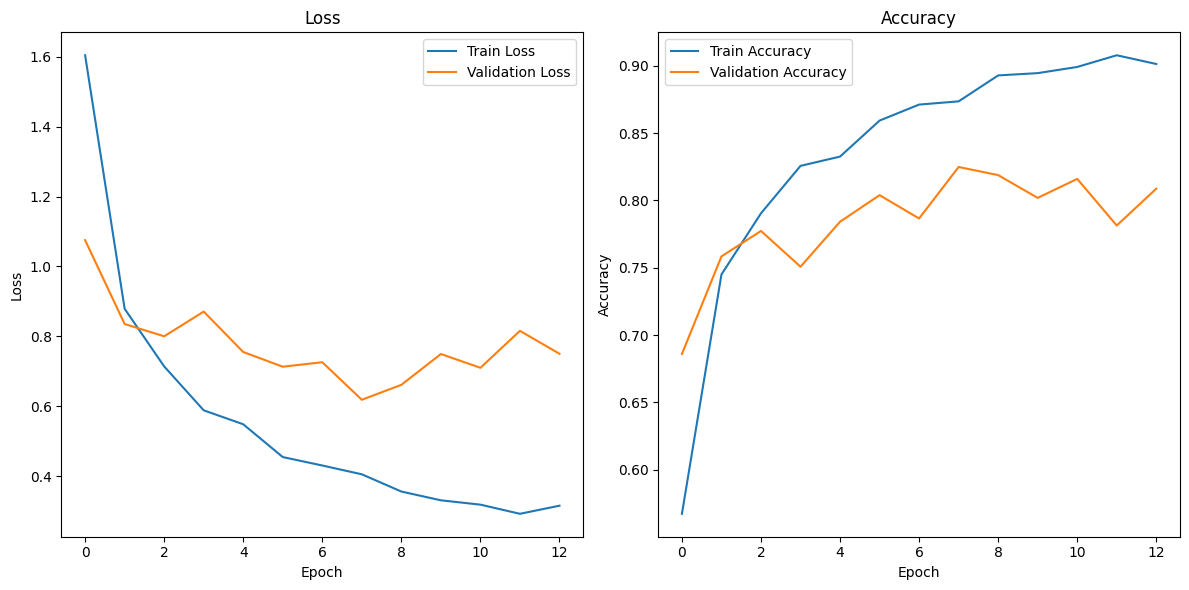

In [23]:
plot_learning_curve(VGG16_hist.history)
save_model(vgg_model, 'VGG16_aug=1')

# Thí nghiệm 2: Tác động của transfer learning và so sánh performance giữa các model

## ResNet101(chưa xong)



In [ ]:
%cd /content/drive/MyDrive/bé\ tập\ Ây\ Ai

[Errno 2] No such file or directory: '/content/drive/MyDrive/bé tập Ây Ai'
/content


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.applications import ResNet101
# from tensorflow.keras import layers, models
# from tensorflow.keras.optimizers import SGD

# resNet101base = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# for layer in resNet101base.layers:
#     layer.trainable = False

# model = models.Sequential([
#     resNet101base,
#     layers.Flatten(),
#     layers.Dense(512, activation='relu'),
#     layers.Dense(45, activation='softmax')
# ])

KeyboardInterrupt: 

In [ ]:
# # Train model
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min')
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-8)

# model.compile(optimizer=SGD(learning_rate=1e-5, momentum=0.5),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# resNet101_hist = model.fit(train_generator, epochs=200, validation_data=validation_generator, callbacks=[early_stopping, reduce_lr])

In [ ]:
# import matplotlib.pyplot as plt

# history_dict = resNet101_hist.history

# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot(history_dict['loss'], label='Train Loss')
# plt.plot(history_dict['val_loss'], label='Validation Loss')
# plt.title('Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history_dict['accuracy'], label='Train Accuracy')
# plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [ ]:
# import json

# with open('history_ResNet101_before_open_layers_no_augmented.json', 'w') as f:
#     json.dump(history_dict, f)

In [ ]:
# # Mở khóa các lớp mô hình để fine-tuning
# for layer in resNet101base.layers:
#     layer.trainable = True

# model.compile(optimizer=SGD(learning_rate=1e-5, momentum=0.3),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# resNet101_hist_fine_tuning = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping])

In [ ]:
# import matplotlib.pyplot as plt

# history_dict = resNet101_hist_fine_tuning.history

# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot(history_dict['loss'], label='Train Loss')
# plt.plot(history_dict['val_loss'], label='Validation Loss')
# plt.title('Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history_dict['accuracy'], label='Train Accuracy')
# plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [ ]:
# model.save('ResNet101_no_augmented.h5')

In [ ]:
# import json

# with open('history_ResNet101_after_open_layers_no_augmented.json', 'w') as f:
#     json.dump(history_dict, f)